# 2023-09-20 Nonlinear solvers

## Last time

* Cost of linear solvers
* Assembling sparse matrices
* Rootfinding intro

## Today

* Newton's method for systems
* Bratu nonlinear PDE
* p-Laplacian
* Techniques for differentiation

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

advdiff_sparse (generic function with 1 method)

# Assembly cost

minimum(diff(x)) = 0.005012531328320691


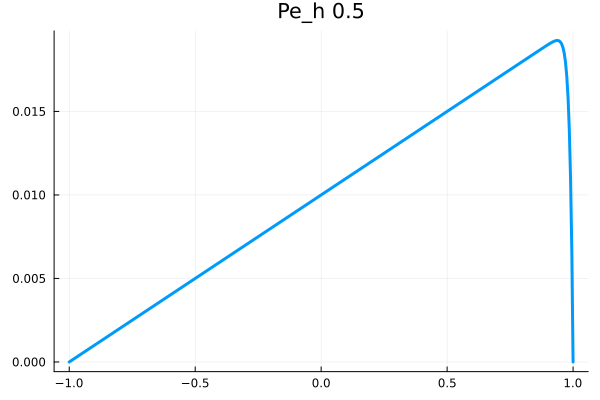

In [2]:
n = 400; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_sparse(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, legend=:none, title="Pe_h $(wind*h/kappa)")

In [3]:
n = 10000
@time advdiff_sparse(n, one, 1, one);

  0.103166 seconds (757.67 k allocations: 44.279 MiB, 13.23% gc time, 51.47% compilation time)


In [4]:
# It's also possible to dynamically insert.
# (But performance this way is generally poor.)
A = spzeros(5, 5)
A[1,1] = 3
A

5×5 SparseMatrixCSC{Float64, Int64} with 1 stored entry:
 3.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [5]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end
eps = 1
newton(x -> eps*(cos(x) - x), x -> eps*(-sin(x) - 1), 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-0.45969769413186023  f'(x)=-1.8414709848078965
[2] x=0.7503638678402439  f(x)=-0.018923073822117442  f'(x)=-1.6819049529414878
[3] x=0.7391128909113617  f(x)=-4.6455898990771516e-5  f'(x)=-1.6736325442243012
[4] x=0.739085133385284  f(x)=-2.847205804457076e-10  f'(x)=-1.6736120293089505
[5] x=0.7390851332151607  f(x)=0.0  f'(x)=-1.6736120291832148


(0.7390851332151607, 0.0, 5)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - f(x_k)/f'(x_k) $$

In [6]:
newton(x -> cos(x) - x, x -> -sin(x) - 1, 3pi/2 + 0.001; verbose=true)

[1] x=4.71338898038469  f(x)=-4.712388980551356  f'(x)=-4.999999583255033e-7
[2] x=-9.424774033259554e6  f(x)=9.424773326519862e6  f'(x)=-0.292526319358701
[3] x=2.2793774188936606e7  f(x)=-2.2793773685912155e7  f'(x)=-0.1357278194645779
[4] x=-1.451436005941369e8  f(x)=1.4514359959518498e8  f'(x)=-0.954228185423985
[5] x=6.962155463251442e6  f(x)=-6.962156426217826e6  f'(x)=-1.2696214789257265
[6] x=1.4785081386104291e6  f(x)=-1.4785074154248144e6  f'(x)=-0.30934627585724994
[7] x=-3.3009494815843664e6  f(x)=3.3009485852473797e6  f'(x)=-0.5566265608245774
[8] x=2.6293255314466488e6  f(x)=-2.629324971066165e6  f'(x)=-1.8282353007342522
[9] x=1.191149072426204e6  f(x)=-1.1911491529894928e6  f'(x)=-1.996749495363329
[10] x=594604.9612317495  f(x)=-594605.3799884742  f'(x)=-1.9080984558468124
[11] x=282983.00159623957  f(x)=-282982.3813435215  f'(x)=-1.7844020434228265
[12] x=124396.32972676173  f(x)=-124396.58315146118  f'(x)=-1.9673551166508052
[13] x=61165.964197618225  f(x)=-61165.300

(0.7390851332151614, -1.3322676295501878e-15, 83)

# Convergence of fixed-point iteration

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{k+1} - x_* = g(x_k) - g(x_*) = g'(c_k) (x_k - x_*) $$
for some $c_i$ between $x_k$ and $x_*$.

Taking absolute values, $$|e_{k+1}| = |g'(c_k)| |e_k|,$$ which converges to zero if $|g'(c_k)| < 1$.

## Exercise

* Write Newton's method for $f(x) = 0$ from initial guess $x_0$ as a fixed point method.
* Suppose the Newton iterates $x_k$ converge to a simple root $x_*$, $x_k \to x_*$. What is $\lvert g'(x_*) \rvert$ for Newton's method?

# Newton for systems of equations

Let $\mathbf u \in \mathbb R^n$ and consider the function $\mathbf f(\mathbf u) \in \mathbb R^n$. Then
$$ \mathbf f(\mathbf u) = \mathbf f(\mathbf u_0) + \underbrace{\mathbf f'(\mathbf u_0)}_{n\times n} \underbrace{\mathbf \delta \mathbf u}_{n\times 1} + \frac 1 2 \underbrace{\mathbf f''(\mathbf u_0)}_{n\times n \times n} {(\delta \mathbf u)^2}_{n\times n} + O(|\delta\mathbf u|^3).$$

We drop all but the first two terms and name the Jacobian matrix $J(\mathbf u) = \mathbf f'(\mathbf u)$,
$$ \mathbf f(\mathbf u) \approx \mathbf f(\mathbf u_0) + J \delta \mathbf u .$$
Solving the right hand side equal to zero yields
\begin{align}
J \delta \mathbf u &= -\mathbf f(\mathbf u_k) \\
\mathbf u_{k+1} &= \mathbf u_k + \delta \mathbf u
\end{align}

# Newton in code


In [7]:
function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

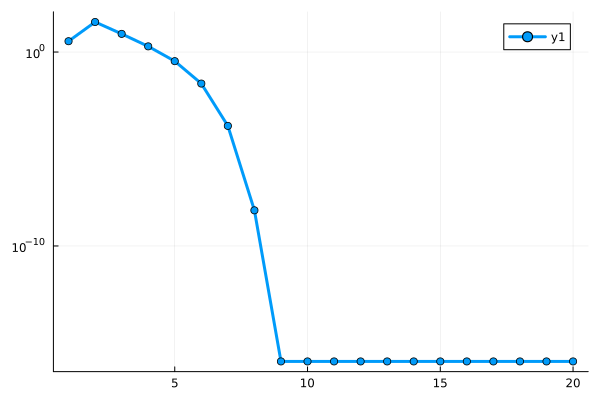

In [8]:
function residual(u)
    x, y = u
    [x^2 + y^2 - 1, x^2 - y]
end
function jacobian(u)
    x, y = u
    [2x 2y; 2x -1]
end

uhist, normhist = newton(residual, jacobian, [0.1, 2])
plot(normhist, marker=:circle, yscale=:log10)

# Plotting the trajectory

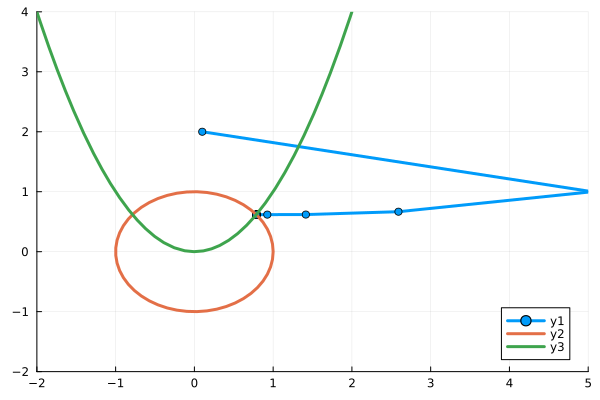

In [9]:
xy = hcat(uhist...)
plot(xy[1,:], xy[2,:], marker=:circle)
circle = exp.(1im*LinRange(0, 2*pi, 50))
plot!(real(circle), imag(circle))
plot!(x -> x^2, xlims=(-2, 5), ylims=(-2, 4), axes=:equal, legend=:bottomright)

# Bratu problem

$$-(u_x)_x - \lambda e^{u}= 0$$

In [10]:
function bratu_f(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    u = copy(u)
    f = copy(u)
    u[1] = 0
    u[n] = 1
    f[n] -= 1
    for i in 2:n-1
        f[i] = weights * u[i-1:i+1] - lambda * exp(u[i])
    end
    f
end

bratu_f (generic function with 1 method)

In [11]:
function bratu_J(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights + [0 -lambda*exp(u[i]) 0])
    end
    sparse(rows, cols, vals)
end

bratu_J (generic function with 1 method)

# Solving Bratu

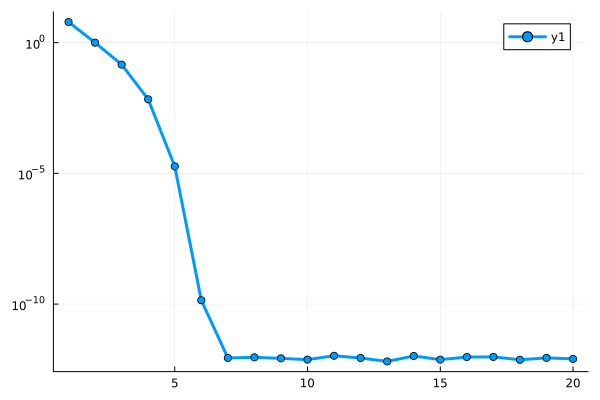

In [12]:
n = 50
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x) ./ 2
uhist, normhist = newton(bratu_f, bratu_J, u0);

plot(normhist, marker=:circle, yscale=:log10)

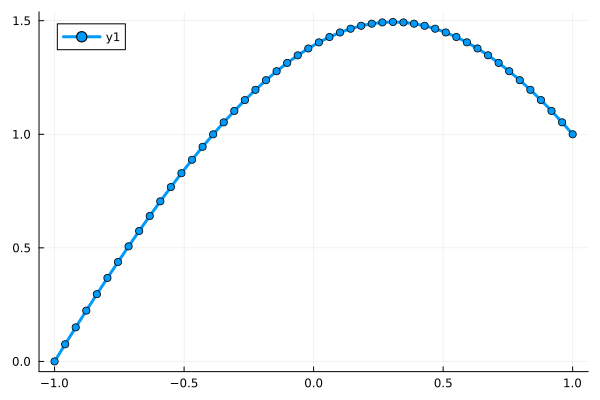

In [13]:
plot(x, uhist[end], marker=:circle)

# $p$-Laplacian

$$ -(|u_x|^{p-2} u_x)_x = 0 $$

In [14]:
plaplace_p = 1.5
plaplace_forcing = 0.
function plaplace_f(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        u_xstag = diff(u[i-1:i+1]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        f[i] = [1/h, -1/h]' *
            (kappa_stag .* u_xstag) - plaplace_forcing
    end
    f
end

plaplace_f (generic function with 1 method)

In [15]:
function plaplace_J(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        u_xstag = diff(u[js]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        fi = [h, -h]' * (kappa_stag .* u_xstag)
        fi_ujs = [-kappa_stag[1]/h^2,
                  sum(kappa_stag)/h^2,
                  -kappa_stag[2]/h^2]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_J (generic function with 1 method)

# Try solving

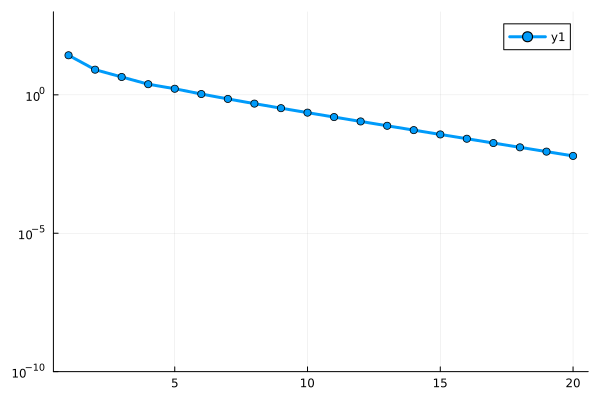

In [16]:
n = 20
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x)

plaplace_p = 1.3 # try different values
plaplace_forcing = 1
uhist, normhist = newton(plaplace_f, plaplace_J, u0; maxits=20);
plot(normhist, marker=:circle, yscale=:log10, ylims=(1e-10, 1e3))

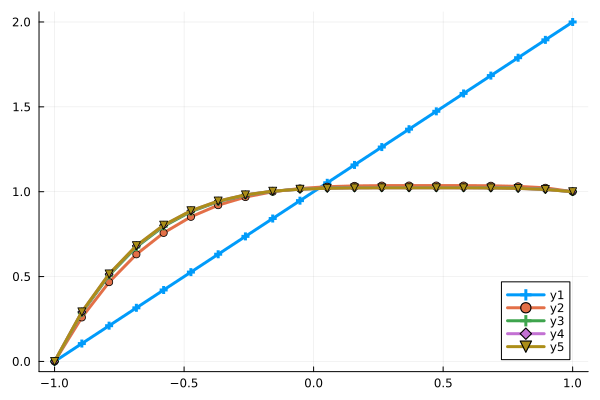

In [17]:
plot(x, uhist[1:5:end], marker=:auto, legend=:bottomright)

## What's wrong?

# Using Zygote to differentiate

In [18]:
using Zygote

gradient(x -> x^2, 3)

(6.0,)

In [19]:
function plaplace_fpoint(u, h)
    u_xstag = diff(u) / h
    kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
    [1/h, -1/h]' * (kappa_stag .* u_xstag)
end

gradient(u -> plaplace_fpoint(u, .1), [0., .7, 1.])

([-7.683385553661419, 21.58727725682051, -13.903891703159092],)

# p-Laplacian with Zygote

In [20]:
function plaplace_fzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        f[i] = plaplace_fpoint(u[i-1:i+1], h) - plaplace_forcing
    end
    f
end

plaplace_fzygote (generic function with 1 method)

In [21]:
function plaplace_Jzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        fi_ujs = gradient(ujs -> plaplace_fpoint(ujs, h), u[js])[1]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_Jzygote (generic function with 1 method)

# Test it out

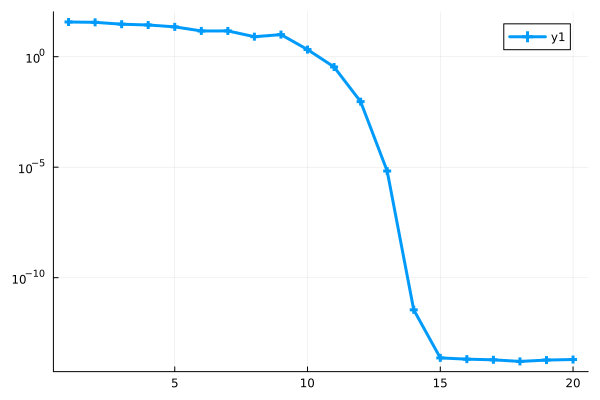

In [22]:
plaplace_p = 1.5
plaplace_forcing = .1
uhist, normhist = newton(plaplace_fzygote, plaplace_Jzygote, u0; maxits=20);
plot(normhist, marker=:auto, yscale=:log10)

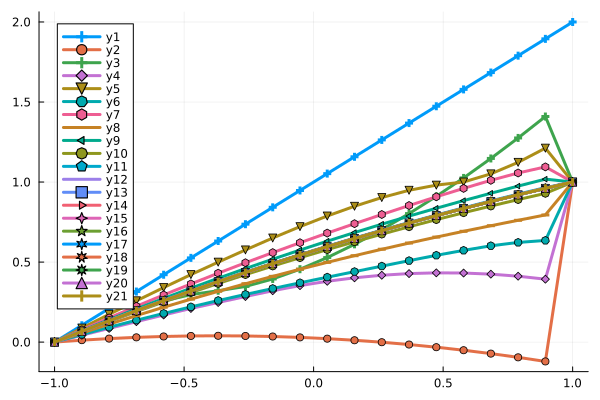

In [23]:
plot(x, uhist, marker=:auto, legend=:topleft)

* Can you fix the `plaplace_J` to differentiate correctly (analytically)?
* What is causing Newton to diverge?
* How might we fix or work around it?

# A model problem for Newton divergence

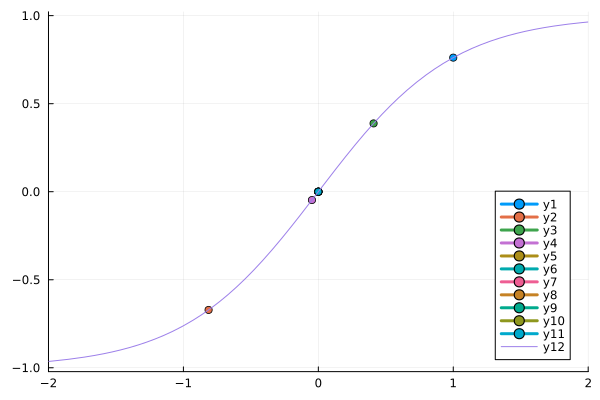

In [24]:
k = 1. # what happens as this is changed
fk(x) = tanh.(k*x)
Jk(x) = reshape(k / cosh.(k*x).^2, 1, 1)
xhist, normhist = newton(fk, Jk, [1.], maxits=10)
plot(xhist, fk.(xhist), marker=:circle, legend=:bottomright)
plot!(fk, xlims=(-2, 2), linewidth=1)

# What about symbolic differentiation?

In [25]:
import Symbolics: Differential, expand_derivatives, @variables
@variables x
Dx = Differential(x)
y = tanh(k*x)
Dx(y)

Differential(x)(tanh(x))

In [26]:
expand_derivatives(Dx(y))

1 - (tanh(x)^2)

# Cool, what about products?

In [27]:
y = x
for _ in 1:1
    y = cos(y^pi) * log(y)
end
expand_derivatives(Dx(y))

cos(x^π) / x - 3.141592653589793(x^2.141592653589793)*log(x)*sin(x^π)

* The size of these expressions can grow **exponentially**.

# Hand coding derivatives: it's all chain rule and associativity
$$ df = f'(x) dx $$

In [28]:
function f(x)
    y = x
    for _ in 1:2
        a = y^pi
        b = cos(a)
        c = log(y)
        y = b * c
    end
    y
end

f(1.9), gradient(f, 1.9)

(-1.5346823414986814, (-34.03241959914049,))

In [29]:
function df(x, dx)
    y = x
    dy = dx
    for _ in 1:2
        a = y^pi
        da = pi * y^(pi-1) * dy
        b = cos(a)
        db = -sin(a) * da
        c = log(y)
        dc = 1/y * dy
        y = b * c
        dy = db * c + b * dc
    end
    dy
end

df(1.9, 1)

-34.03241959914048

# We can go the other way

We can differentiate a composition $h(g(f(x)))$ as

\begin{align}
  \operatorname{d} h &= h' \operatorname{d} g \\
  \operatorname{d} g &= g' \operatorname{d} f \\
  \operatorname{d} f &= f' \operatorname{d} x.
\end{align}

What we've done above is called "forward mode", and amounts to placing the parentheses in the chain rule like

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

The expression means the same thing if we rearrange the parentheses,

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

which we can compute with in reverse order via

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

# A reverse mode example

$$ \underbrace{\bar x}_{\frac{dh}{dx}} = \underbrace{\bar g \frac{dg}{df}}_{\bar f} \frac{df}{dx} .$$

In [30]:
function g(x)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    y
end
(g(1.4), gradient(g, 1.4))

(-0.32484122107701546, (-1.2559761698835525,))

In [31]:
function gback(x, y_)
    a = x^pi
    b = cos(a)
    c = log(x)
    y = b * c
    # backward pass
    c_ = y_ * b 
    b_ = c * y_
    a_ = -sin(a) * b_
    x_ = 1/x * c_ + pi * x^(pi-1) * a_
    x_
end
gback(1.4, 1)

-1.2559761698835525

# Kinds of algorithmic differentation

* Source transformation: Fortran code in, Fortran code out
  * Duplicates compiler features, usually incomplete language coverage
  * Produces efficient code
* Operator overloading: C++ types
  * Hard to vectorize
  * Loops are effectively unrolled/inefficient
* Just-in-time compilation: tightly coupled with compiler
  * JIT lag
  * Needs dynamic language features (JAX) or tight integration with compiler (Zygote, Enzyme)
  * Some [sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow)

# How does Zygote work?

In [32]:
h1(x) = x^3 + 3*x
h2(x) = ((x * x)  + 3) * x
@code_llvm h1(4.)

;  @ In[32]:1 within `h1`
define double @julia_h1_6764(double %0) #0 {
top:
; ┌ @ intfuncs.jl:320 within `literal_pow`
; │┌ @ operators.jl:578 within `*` @ float.jl:410
    %1 = fmul double %0, %0
    %2 = fmul double %1, %0
; └└
; ┌ @ promotion.jl:411 within `*` @ float.jl:410
   %3 = fmul double %0, 3.000000e+00
; └
; ┌ @ float.jl:408 within `+`
   %4 = fadd double %3, %2
; └
  ret double %4
}


In [33]:
@code_llvm gradient(h1, 4.)

;  @ /home/jed/.julia/packages/Zygote/4rucm/src/compiler/interface.jl:95 within `gradient`
define [1 x double] @julia_gradient_6807(double %0) #0 {
top:
;  @ /home/jed/.julia/packages/Zygote/4rucm/src/compiler/interface.jl:97 within `gradient`
; ┌ @ /home/jed/.julia/packages/Zygote/4rucm/src/compiler/interface.jl:45 within `#75`
; │┌ @ In[32]:1 within `Pullback`
; ││┌ @ /home/jed/.julia/packages/Zygote/4rucm/src/compiler/chainrules.jl:211 within `ZBack`
; │││┌ @ /home/jed/.julia/packages/Zygote/4rucm/src/lib/number.jl:12 within `literal_pow_pullback`
; ││││┌ @ intfuncs.jl:319 within `literal_pow`
; │││││┌ @ float.jl:410 within `*`
        %1 = fmul double %0, %0
; ││││└└
; ││││┌ @ promotion.jl:411 within `*` @ float.jl:410
       %2 = fmul double %1, 3.000000e+00
; │└└└└
; │┌ @ /home/jed/.julia/packages/Zygote/4rucm/src/lib/lib.jl:17 within `accum`
; ││┌ @ float.jl:408 within `+`
     %3 = fadd double %2, 3.000000e+00
; └└└
;  @ /home/jed/.julia/packages/Zygote/4rucm/src/compiler/inter

# Forward or reverse?

It all depends on the shape.

$$ \operatorname d h = \frac{dh}{dg} \left(\frac{dg}{df} \left(\frac{df}{dx} \operatorname d x \right) \right) .$$

$$ \operatorname d h = \left( \left( \left( \frac{dh}{dg} \right) \frac{dg}{df} \right) \frac{df}{dx} \right) \operatorname d x $$

* One input, many outputs: use forward mode
  * "One input" can be looking in one direction
* Many inputs, one output: use reverse mode
  * Will need to traverse execution backwards ("tape")
  * Hierarchical checkpointing
* About square? Forward is usually a bit more efficient.